In [147]:
using Images, TestImages, ImageIO, ImageMagick, ImageView, Colors
using StatsBase, Statistics, LinearAlgebra, Plots, Random
using Flux

In [148]:
NN = 10 #side length of images generated

function noisySquare() #make a 'noisy' square image
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( (rr >= 3 && rr <= 7) && (cc >= 3 && cc <= 7) )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

function noisyCross() #function 'noisy cross' image generator
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( rr == 5 || cc == 5 )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

noisyCross (generic function with 1 method)

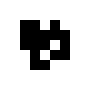

In [149]:
Gray.( noisySquare() ) #make a sample noisy square

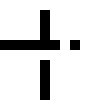

In [150]:
Gray.( noisyCross() ) #make a sample cross

In [151]:
img_Num = 100 #number of images of each type to generate

100

In [152]:
squares = [vec(noisySquare()) for i in 1:img_Num];
crosses = [vec(noisyCross()) for i in 1:img_Num];

In [153]:
Gray.(squares[1])

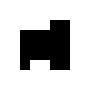

In [154]:
reshape( Gray.(squares[1]) , NN , NN )

In [155]:
real_data = vcat( squares , crosses ); #real data examples

(100, 200)

(10, 10, 200)

(10, 10, 1, 200)

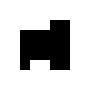

In [156]:
#data must be in WxHxCxN but for generator it is 1 d entry so that is WxHxCxN we reshape
tmp = Flux.stack( real_data , dims=2 )
display( size( tmp ) )
tmp = reshape( tmp , (10,10,200) )
display( size( tmp ) )
real_data_WHCN = Flux.unsqueeze( tmp , dims = 3 ) # WHCN format as needed
display( size( real_data_WHCN ) )
Gray.( real_data_WHCN[ : , : , 1 , 1 ] )

In [157]:
real_data_labels = Int.([ ones( 100 ) ; 2*ones(100) ]); #the labels associated with the real data
display( size(real_data_labels) )
display( real_data_labels[ 1 ] )
display( real_data_labels[ end ] )

(200,)

1

2

In [158]:
latent_dim = 10

10

In [159]:
function MakeZvectors( labels ) #make z samples with the label information concatenated
    z = rand( latent_dim , length(labels) )
    z_label = repeat( labels' , latent_dim , 1 )
    return cat( z_label , z , dims=1 ) #joint representation of the embedding of the label and noise vector z
end

MakeZvectors (generic function with 1 method)

In [160]:
MakeZvectors( [1,2,1] ) #look at the representation of latent z and the label information

20×3 Matrix{Float64}:
 1.0        2.0       1.0
 1.0        2.0       1.0
 1.0        2.0       1.0
 1.0        2.0       1.0
 1.0        2.0       1.0
 1.0        2.0       1.0
 1.0        2.0       1.0
 1.0        2.0       1.0
 1.0        2.0       1.0
 1.0        2.0       1.0
 0.920681   0.561323  0.785228
 0.0672181  0.911483  0.165275
 0.671461   0.645505  0.707104
 0.491188   0.210563  0.554447
 0.101733   0.344742  0.768157
 0.357424   0.238695  0.758172
 0.738147   0.644733  0.496832
 0.201064   0.761424  0.172005
 0.635375   0.442135  0.498808
 0.587795   0.828867  0.602551

In [161]:
m_gen = Chain( 
      Dense( 2*latent_dim => 100 ) , 
      BatchNorm( 100 , relu ) ,
      x->reshape( x , 5 , 5 , 4 , : ) , #make into WHCN
      ConvTranspose( (4,4) , 4 => 2 ; stride = 1, pad = 1 ) ,
      BatchNorm( 2 , relu ) ,
      ConvTranspose( (5,5) , 2 => 1 ; stride = 1, pad = 1 ) , 
      ConvTranspose( (5,5) , 1 => 1 ; stride = 1, pad = 1 ) , 
      sigmoid
    );

In [162]:
m_gen( MakeZvectors( [2] ) )

10×10×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.502404  0.47573   0.480301  0.497453  …  0.539037  0.560455  0.54374
 0.488364  0.510432  0.512271  0.517946     0.587033  0.541935  0.504415
 0.498529  0.530078  0.497581  0.504732     0.523385  0.476487  0.502525
 0.509282  0.486027  0.508568  0.540998     0.638561  0.626637  0.543731
 0.498227  0.517371  0.562421  0.588922     0.586688  0.521814  0.472838
 0.447443  0.485256  0.455819  0.525703  …  0.579114  0.483596  0.486784
 0.435088  0.455115  0.428297  0.534509     0.464425  0.462713  0.460069
 0.379708  0.473971  0.320817  0.417265     0.332732  0.398082  0.456449
 0.427736  0.442823  0.362529  0.39396      0.402571  0.440656  0.478685
 0.466222  0.419854  0.405614  0.339122     0.430717  0.464467  0.486139

(10, 10, 1, 4)

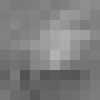

In [163]:
display( size( m_gen( MakeZvectors( [1,2,2,1] ) ) ) )
Gray.( m_gen(MakeZvectors([2]))[:,:,1,1] )

In [164]:
m_dis = Chain( #discriminator takes in 2 channel data, the pixel info in 1 and the label info on the next
      Conv( (4,4) , 2 => 2 , stride = 1 , pad = 1 ) ,
      relu ,
      Conv( (4,4) , 2 => 1 , stride = 1 , pad = 1 ) ,
      relu ,
      Flux.flatten ,
      Dense( 64 => 10 , relu ) ,
      Dense( 10 => 1 ) ,
      sigmoid
    );

In [165]:
m_emb = Chain( Embedding( 2=>NN*NN ), x->reshape(x,10,10,1,size(x,2)) );#2 class embedding -> number of pixels

In [166]:
m_emb([1]) #see the embedding of the label information

10×10×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
  0.303473   -1.25887     0.0991739  …  -1.49069   -0.507949   -0.26818
 -0.0507493   0.196841   -1.16664        0.267415   0.0217753   0.928822
  1.99339    -0.839261   -0.394494       0.496567   1.33482     0.478301
 -0.382207   -0.84235    -1.63277       -0.654362  -0.559953    0.887123
  0.607365   -0.327247    0.0825089      0.926999   1.23168    -1.49409
 -0.558398   -0.797137   -0.511475   …   0.96521   -1.65689    -0.775915
 -0.985065    0.474573   -1.16452       -0.699534   0.712537   -1.25045
  0.032967    0.0910091  -0.890363      -0.372063  -1.91707     0.575774
 -0.651452   -0.731071   -0.715922       1.10728    0.707539   -0.666317
  0.851099   -1.09426     0.717796      -0.200113   0.0762063   0.959818

In [167]:
cat( m_gen(MakeZvectors([2])) , m_emb([1]) , dims=3 ) #do the channel data augmentation

10×10×2×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.503993  0.479524  0.478019  0.496552  …  0.538743  0.562873  0.540041
 0.491903  0.505865  0.503639  0.512243     0.582917  0.536773  0.501975
 0.503203  0.531334  0.498199  0.50281      0.514255  0.486074  0.510896
 0.507538  0.489025  0.496026  0.540751     0.647202  0.619993  0.537267
 0.505419  0.523413  0.560696  0.610746     0.594435  0.519504  0.475309
 0.44927   0.467981  0.464106  0.509464  …  0.565278  0.490207  0.48867
 0.436416  0.455119  0.438719  0.533596     0.461253  0.458868  0.457358
 0.376031  0.471123  0.312649  0.42408      0.336973  0.401017  0.460021
 0.431699  0.442401  0.356607  0.394893     0.396086  0.438903  0.476916
 0.467534  0.417446  0.400732  0.336005     0.430865  0.465915  0.486888

[:, :, 2, 1] =
  0.303473   -1.25887     0.0991739  …  -1.49069   -0.507949   -0.26818
 -0.0507493   0.196841   -1.16664        0.267415   0.0217753   0.928822
  1.99339    -0.839261   -0.394494       0.496567   1.33482     0.

In [168]:
labels_tmp = [1,2,1,2]
display( size( cat( m_gen( MakeZvectors(labels_tmp)) , m_emb(labels_tmp) , dims=3 ) ) ) #check size
m_dis( cat( m_gen( MakeZvectors(labels_tmp)) , m_emb(labels_tmp) , dims=3 ) ) #check discriminator output

(10, 10, 2, 4)

1×4 Matrix{Float64}:
 0.494611  0.491774  0.494193  0.491894

In [169]:
inds_tmp = [1,50,150,200]
labels_tmp = real_data_labels[ inds_tmp ]
m_dis( cat( real_data_WHCN[:,:,:,inds_tmp] , m_emb(labels_tmp) , dims=3 ) ) #feeding real data

1×4 Matrix{Float64}:
 0.502449  0.500655  0.496557  0.498814

In [170]:
function generator_loss( fake_output ) 
    Flux.logitbinarycrossentropy( fake_output , 1 )
end
function discriminator_loss( real_output , fake_output )
    real_loss = Flux.logitbinarycrossentropy( real_output , 1 )
    fake_loss = Flux.logitbinarycrossentropy( fake_output , 0 )
    return real_loss + fake_loss
end

discriminator_loss (generic function with 1 method)

In [171]:
function train_generator( gen , dscr , emb , opt_gen , labels )
    loss, grads = Flux.withgradient( gen ) do gen
        dis_output = dscr( cat( gen( MakeZvectors(labels)) , emb(labels) , dims=3 ) )
        generator_loss( dis_output )        
    end
    Flux.update!( opt_gen , gen , grads[1] )
    return loss
end

train_generator (generic function with 1 method)

In [172]:
function train_discriminator( gen , dscr , emb , x , opt_dscr , opt_emb , labels )
    
    loss, grads = Flux.withgradient(dscr,emb) do dscr,emb #train the discriminator and embedding
        gen_output = cat( gen( MakeZvectors(labels)) , emb(labels) , dims=3 )
        real_output = cat( x , emb(labels) , dims=3 )
        discriminator_loss( dscr( real_output ) , dscr( gen_output ) )
    end
    Flux.update!( (opt_dscr,opt_emb) , (dscr,emb) , grads ) #update parameters of both disc and emb
    return loss
end

train_discriminator (generic function with 1 method)

In [173]:
opt_dis = Flux.setup( Adam( 0.0005 ) , m_dis );
opt_gen = Flux.setup( Adam( 0.0005 ) , m_gen );
opt_emb = Flux.setup( Adam( 0.0005 ) , m_emb );

In [174]:
display( train_discriminator( m_gen , m_dis , m_emb , real_data_WHCN[:,:,:,1:2] , opt_dis , opt_emb , [1,1] ) )
display( train_generator( m_gen , m_dis , m_emb , opt_gen , [1,2] ) )

1.4464935137566064

0.4764653887199121

In [175]:
loss_dis_array = []
loss_gen_array = []

Any[]

In [176]:
batch_num = 10

for epoch in 1:100_000
    
    tmp_inds = Random.randperm(length(real_data_labels))[1:batch_num]
    labels_tmp = real_data_labels[ tmp_inds ]
    
    x_real_tmp = real_data_WHCN[:,:,:,tmp_inds]
            
    loss_dis = train_discriminator( m_gen , m_dis , m_emb , x_real_tmp , opt_dis , opt_emb , labels_tmp )
    push!( loss_dis_array , loss_dis )
    
    loss_gen = train_generator( m_gen , m_dis , m_emb , opt_gen , labels_tmp )
    push!( loss_gen_array , loss_gen )
    
end

In [177]:
p_dis = plot( loss_dis_array , title="discriminator loss" )
p_gen = plot( loss_gen_array , title="generator loss" )
plot( p_dis , p_gen )

In [178]:
inds_tmp = [1,50,150,200]
labels_tmp = real_data_labels[ inds_tmp ]
m_dis( cat( real_data_WHCN[:,:,:,inds_tmp] , m_emb(labels_tmp) , dims=3 ) ) #feeding real data

1×4 Matrix{Float64}:
 1.21356e-15  4.67275e-14  5.37909e-16  8.26999e-19

In [179]:
labels_tmp = [1,2,1,2]
display( m_dis( cat( m_gen( MakeZvectors(labels_tmp)) , m_emb(labels_tmp) , dims=3 ) ) ) #check discriminator output

1×4 Matrix{Float64}:
 2.53927e-14  1.53166e-19  8.43836e-14  1.81785e-20

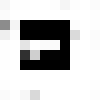

In [180]:
Gray.(m_gen( MakeZvectors(labels_tmp))[:,:,1,1])

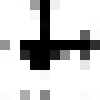

In [181]:
Gray.(m_gen( MakeZvectors(labels_tmp))[:,:,1,4])

In [182]:
m_emb([1]) #see the embedding of the label information

10×10×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
  0.458543   -1.35508      0.257633   …  -1.28722   -0.673838    -0.106229
  0.0542379   0.133877    -1.34445        0.397695  -0.116387     1.0713
  2.1385     -0.808097    -0.506199       0.604906   1.36828      0.175965
 -0.544745   -0.663735    -1.68284       -0.948714  -0.49077      0.873284
  0.456013   -0.0834593    0.0681509      0.842263   1.25257     -1.68752
 -0.517444   -0.650699    -0.496695   …   1.26779   -2.08377     -0.489348
 -1.0305      0.553859    -1.10299       -0.519808   0.360144    -1.11623
  0.141327    0.00822911  -0.841546      -0.236253  -2.12515      0.644023
 -0.791399   -0.746744    -0.71219        0.887166   0.690835    -0.577396
  0.781337   -1.07317      0.62499       -0.305678  -0.00582407   0.741527

In [183]:
#############################################3